In [1]:
%pip install -q numpy pandas matplotlib tensorflow scikit-learn setuptools keras-tuner setuptools

Note: you may need to restart the kernel to use updated packages.


In [2]:
#run once
import os
os.chdir('../')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras_tuner import HyperModel
import keras_tuner
from tensorflow.keras.metrics import RootMeanSquaredError

C:\Users\jfsal\AppData\Local\Temp\ipykernel_10712\925452313.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [4]:
#Data Setup
data = pd.read_csv(r'Data\Building_Data_Preprocessed.csv')

data = data.drop('BuildingName', axis = 1)
data = data.drop('Address', axis = 1)

X = data.drop('GHGEmissionsIntensity', axis = 1)
y = data['GHGEmissionsIntensity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
class GHGHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        model.add(layers.BatchNormalization())

        for i in range(hp.Int('num_layers', 1, 10)):
            units = hp.Int('units_' + str(i), 
                           min_value = 64,
                           max_value = 1028,
                           step = 64)
            
            model.add(layers.Dense(units=units, activation='relu'))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(hp.Float('dropout_' + str(i),
                                              min_value=0.0,
                                              max_value=0.5,
                                              step=0.1)))
        model.add(layers.Dense(1, activation='linear'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-7,
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss='mse',
            metrics=['mean_absolute_error', RootMeanSquaredError()]
        )
        return model

from keras_tuner import RandomSearch

tuner = RandomSearch(
    GHGHyperModel(),
    objective='val_root_mean_squared_error',
    max_trials=100,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train with each hyperparameter combination
    directory='Code/GHGNNTuning',
    project_name='GHG Emissions Prediction',
    
)

#********************#
MY_PATIENCE = 20
MY_EPOCHS = 500
MY_MIN_DELTA = 0.001
#********************#

In [ ]:
#This code also runs for a long time, half an hour, because it trains the model.
tuner.search(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = MY_EPOCHS,
    callbacks = [keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)], #prevent overfitting
    verbose = 1
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', RootMeanSquaredError()])

Trial 16 Complete [00h 05m 02s]
val_root_mean_squared_error: 2.720181703567505

Best val_root_mean_squared_error So Far: 2.6941471099853516
Total elapsed time: 00h 42m 17s

Search: Running Trial #17

Value             |Best Value So Far |Hyperparameter
8                 |8                 |num_layers
448               |128               |units_0
0.1               |0.4               |dropout_0
8.9629e-07        |0.0036684         |learning_rate
128               |832               |units_1
0                 |0.3               |dropout_1
384               |832               |units_2
0.1               |0.3               |dropout_2
320               |128               |units_3
0.4               |0                 |dropout_3
768               |960               |units_4
0.3               |0.3               |dropout_4
128               |128               |units_5
0.4               |0.1               |dropout_5
320               |128               |units_6
0.3               |0                

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5833 - mean_squared_error: 3.5833 - root_mean_squared_error: 1.8894 - val_loss: 7.3582 - val_mean_squared_error: 7.3582 - val_root_mean_squared_error: 2.7126
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5100 - mean_squared_error: 3.5100 - root_mean_squared_error: 1.8678 - val_loss: 7.2964 - val_mean_squared_error: 7.2964 - val_root_mean_squared_error: 2.7012
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3106 - mean_squared_error: 3.3106 - root_mean_squared_error: 1.8113 - val_loss: 7.2867 - val_mean_squared_error: 7.2867 - val_root_mean_squared_error: 2.6994
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7031 - mean_squared_error: 3.7031 - root_mean_squared_error: 1.9206 - val_loss: 7.3325 - val_mean_squared_error: 7.3325 - val_root_mean_squared_error: 2.7079
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3203 - mean_squared_error: 3.3203 - root_mean_squared_error: 1.

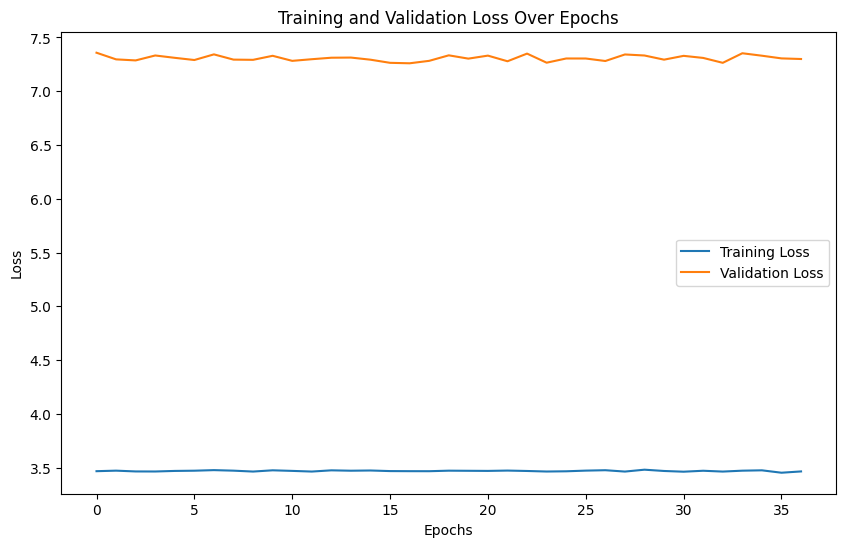

In [ ]:
#evaluate the best model from the tuning
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f'Neural Network Accuracy: {accuracy:.4f}')

#Plot Training and Validation Loss
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=MY_EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)],
    verbose=1
)

plt.figure(figsize=(12, 8))

# Plotting Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plotting Training and Validation MSE
plt.subplot(2, 1, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation MSE and RMSE Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#get units of predicted column for context
# Calculate the range of the column
min_value =data['GHGEmissionsIntensity'].min()
max_value = data['GHGEmissionsIntensity'].max()
range_value = max_value - min_value

# Print the range
print(f"Range of 'column_name': {range_value}")

#### Write Up
This neural network approach is fairly accurate for predicting total emissions output based on the features provided. The two important metrics to evaluate this model are the Loss and the Root Mean Squared Error. The Loss tells us how well the model is predicting values (predicted vs actual). In this case I chose to use Mean Squared Error which is the average squared difference between predicted and actual. The Root Mean Squared Error evaluates the performance of the regression model. It is the square root of the squared difference between the predicted and actual values. 

They are essentially the same thing, RMSE being MSE after square rooting however they serve different functions to the model and its training process. Loss is minimized by the optimizer of the function during training while RMSE is used afterwards to evaluate the model. RMSE Shows the average of the magnitude of the errors in the same unit as the target while MSE helps identify large errors.

In this case this model performs quite well. The best performing model had an RMSE of just under 3 which means that its predictions for emission intensity are off by about 3 units